In [1]:
from scipy.stats import norm, multivariate_normal
import math
from math import e
from numpy import linalg as LA
from numpy.linalg import inv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Why

Gaussian mixtures models are used in HMM-GMM models. The GMM give us the emission probabilities. E.g. Given a certain MFCC we have to determine the most likely phone. In this notebook I implement an unsupervised algorithm, Expected Maximization to find the optimal parameters (pis,means,covariances) for the Gaussian Mixtures Models.

# Intro

  A quick recap on some concepts. The likelihood is a specific case of a probability. In a GMM scenario  <b> likelihood is the same as the probability of an instance given a certain cluster </b>. <p style ="color:red;"> It is wrong saying the likelihood of a cluster given an instance. <style>
# EM

The first step in this algorithm is the expectation step. Which does the following:

Given clusters A,B... and instances x1,x2:

1. It estimates the likelihood of a all instances belonging to a certain classes. (e.g. P(x1|A))

2. Then, using bayesian rule estimates the P(A|x1) = π1





# EM

The pis(πs) are just scalars that multiply with the clusters, letting us consequently have a model with cluster of different sizes (The bigger the pi, the bigger the cluster, the more higher the probability of the cluster).

## EXPECTATION STEP

1. Calculate the likelihood of an instance given a certain cluster (for all instances and clusters)
2. Multiply the likelihood by the pis (Since the clusters have different sizes)
3. Calculate the posterior probabilities,P(cluster|instance), <b> eg: P(A|X1) </b>

The following picture shows some manipulations in order to get the desired posterior probabilities:


<img src="images/expectationStep.gif" height=50> 


In [2]:
'''
This function creates a 2d density plot featuring the 
GMMs and the data points so we can visualize what is going on.
'''
#data,means,covs,title
def plot_contours(gmm, title):
    data = gmm.get_data()
    plt.figure(figsize=(10,10))
    plt.plot(data[:, 0], data[:, 1], 'ko')

    delta = 0.025
    k = len(list(gmm.get_clusters().keys()))
    x = np.arange(-2.0, 7.0, delta)
    y = np.arange(-2.0, 7.0, delta)
    x_grid, y_grid = np.meshgrid(x, y)
    coordinates = np.array([x_grid.ravel(), y_grid.ravel()]).T
    
    clusters = gmm.get_clusters()

    col = ['green', 'red','blue']
    patches = []
    keys = list(clusters.keys())
    for i in range(0,len(keys)):
        key = keys[i]
        mean = clusters[key]["mean"]
        cov = clusters[key]["cov"]

        z_grid = multivariate_normal(mean, cov, allow_singular=True).pdf(coordinates).reshape(x_grid.shape)
        patches.append(mpatches.Patch(color=col[i], label=key))
        plt.contour(x_grid, y_grid, z_grid, colors = col[i])

    plt.legend(handles=patches)
    plt.title(title)
    plt.tight_layout()
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()

In [3]:
class GMM:
    '''
     GMM's are created from:
         -an array of array with means.
         -an array of array with covariances.
         -an array of numbers with p's.
    '''
    def __init__(self, m, c, p,instances):
        self.clusters = {}
        print("o len de m e: " + str(len(m)))
        for ind in range(0,len(m)):
            tmp = {}
            tmp["mean"] = m[ind]
            tmp["cov"] = c[ind]
            tmp["pi"] = p[ind]
            self.clusters["c" + str(ind)] = tmp
            
            self.n = None
            self.instances = instances
            self.posterior_probs = []
    
    '''Getters'''
    def get_clusters(self): return self.clusters

    #returns an array with all pis
    def get_pis(self):
        tmp = []
        for key in list(self.clusters.keys()):
            tmp.append(self.clusters[key]["pi"])
        return tmp
    
    #returns an array with all instances.
    def get_data(self): return self.instances
    
    #returns an array with all covariances.
    def get_covs(self):
        tmp = []
        for key in list(self.clusters.keys()):
             tmp.append(self.clusters[key]["cov"])
        return np.array(tmp)
    
    #returns an array with all means
    def get_means(self):
        tmp = []
        for key in list(self.clusters.keys()):
             tmp.append(self.clusters[key]["mean"])
        return np.array(tmp)     
        
    def compute_likelihood(self,x,mean,cov):
        return 1/(2*math.pi) * (1/(pow(np.linalg.det(cov),0.5))) * \
        pow(e,-0.5* np.dot(np.transpose(x-mean) , np.dot(inv(cov),(x-mean)))) 
    '''
    Calculates likelihood of a given instance for a multivariate gaussian
    as an array of arrays where there is an array for each clusters that has the non-normalized
    probabilities of the instance belonging to that cluster.
    '''
    def calc_likelihood(self):
        res = {}
        for key in self.clusters.keys():
            instances_per_cluster = []
            for x in self.instances:
                mean = self.clusters[key]["mean"]
                cov = self.clusters[key]["cov"]
                
                likelihood = self.compute_likelihood(x,mean,cov)
                instances_per_cluster.append(likelihood)
                    
            res[key] = instances_per_cluster
        self.posterior_probs = res
        
            
    def calc_posterior(self):
        posteriors = []
        
        #calc denominator:
        den = np.zeros(len(self.instances))
        for key in list(self.posterior_probs.keys()):
            tmp = np.dot(self.posterior_probs[key],self.clusters[key]["pi"])
            den = np.add(den,tmp)
            
        res = {}
        for key in list(self.posterior_probs.keys()):
            res[key] = np.dot(self.posterior_probs[key],self.clusters[key]["pi"]) / den
        self.posterior_probs = res
        
    def pred_cluster(self,x):
        cluster_vals = {}
        for key in list(self.clusters.keys()):
            mean = self.clusters[key]["mean"]
            cov = self.clusters[key]["cov"]    
            likelihood = self.compute_likelihood(x,mean,cov)
            cluster_vals[key] = likelihood
        
        most_probable_cluster = None
        most_probable_cluster_value = 0
        for key in cluster_vals.keys():
            if cluster_vals[key] > most_probable_cluster_value:
                most_probable_cluster_value = cluster_vals[key]
                most_probable_cluster = key
        print("Instances " + str(x) + " belongs to the cluster " + str(most_probable_cluster))
            
        
    def calc_n(self):
        n = {}
        for key in list(self.posterior_probs.keys()):
            n[key] = np.sum(self.posterior_probs[key])
        self.n = n
        
    #Updates the mean value for each variable of each cluster
    def update_mean(self):
        for key in list(self.posterior_probs.keys()):
            tmp = 0
            cluster_probs = self.posterior_probs[key]
            for x in range(0,len(cluster_probs)):
                tmp += cluster_probs[x] * self.instances[x]
            self.clusters[key]["mean"] = 1/self.n[key] * tmp
            
    #update the covariance matrix of each cluster.
    def update_covariance(self):
        for key in list(self.posterior_probs.keys()):
            tmp = 0
            cluster_probs = self.posterior_probs[key]
            for x in range(0,len(cluster_probs)):
                sub = np.array([np.subtract(self.instances[x],self.clusters[key]["mean"])])
                tmp += cluster_probs[x] * np.dot(sub.T,sub)
            tmp = 1/self.n[key] * tmp
            self.clusters[key]["cov"] = tmp
            
    #updatethe prior mixture weights of the gaussians.
    def update_pis(self):
        soma_pis = 0
        for key in list(self.clusters.keys()):
            soma_pis += self.n[key]
        for key in list(self.clusters.keys()):
            self.clusters[key]["pi"] = self.n[key] /soma_pis
        
    def EM(self):
        self.calc_likelihood()
        self.calc_posterior()
        self.calc_n()
        self.update_mean()
        self.update_covariance()
        self.update_pis()
    


# Example without using K-Means to initialize the clusters means and covariance:

o len de m e: 3
==============NOVA ITERACAO=================================
means: [[2 2]
 [0 0]
 [1 1]]
covs: [[[1.  0.1]
  [0.9 1. ]]

 [[1.  0. ]
  [0.  1. ]]

 [[1.  0. ]
  [0.  1. ]]]
pis: [0.33, 0.33, 0.33]


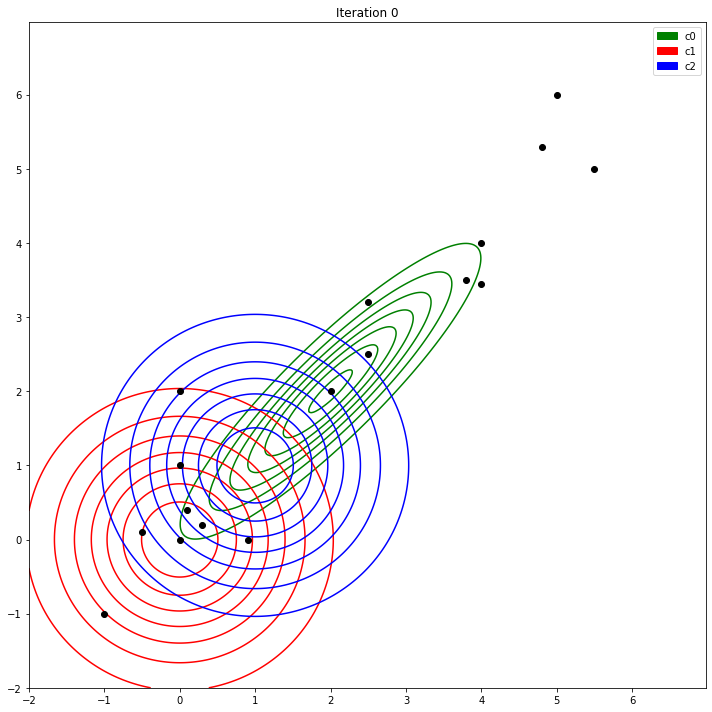

==============NOVA ITERACAO=================================
means: [[ 3.5335059   3.66838493]
 [-0.14252481  0.0806248 ]
 [ 0.42830123  0.91407396]]
covs: [[[2.30165601 2.12881638]
  [2.12881638 2.29815882]]

 [[0.33127065 0.2335454 ]
  [0.2335454  0.52173195]]

 [[0.66684903 0.35342682]
  [0.35342682 0.89158337]]]
pis: [0.5538442849755918, 0.2697554641818869, 0.1764002508425213]


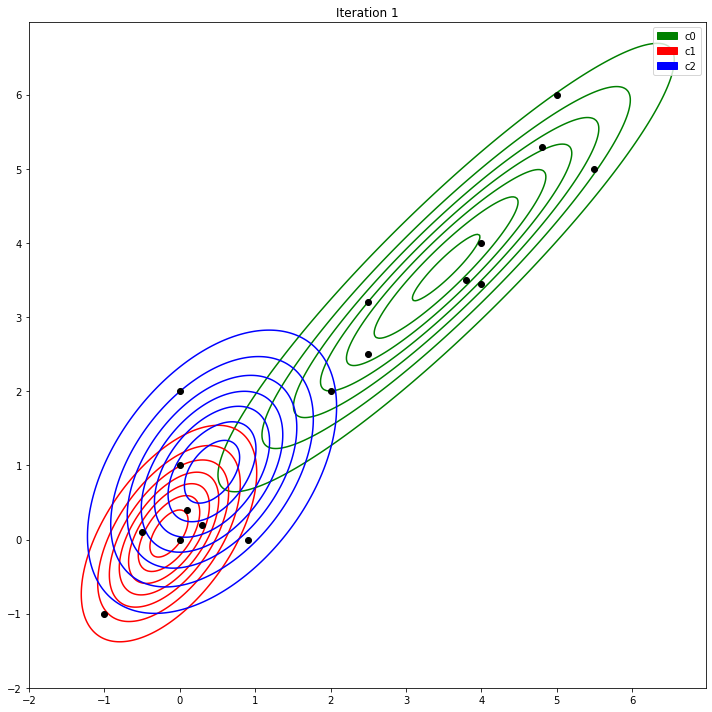

==============NOVA ITERACAO=================================
means: [[ 3.67964266  3.7725356 ]
 [-0.13130661  0.08038322]
 [ 0.23009833  0.87807543]]
covs: [[[1.74186598 1.72160172]
  [1.72160172 1.97024456]]

 [[0.27900465 0.19555453]
  [0.19555453 0.39730363]]

 [[0.35951169 0.04835684]
  [0.04835684 0.88238758]]]
pis: [0.5417907471017012, 0.2902890158324963, 0.16792023706580245]


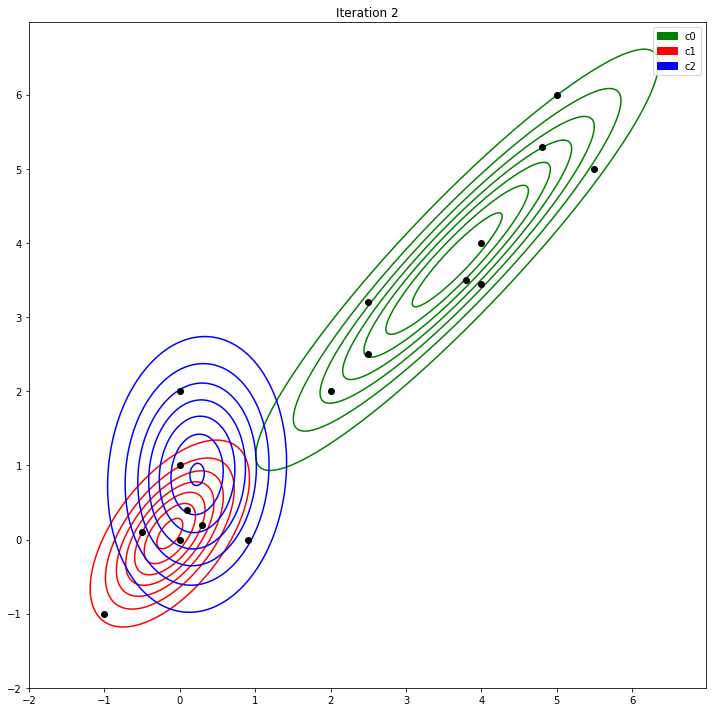

==============NOVA ITERACAO=================================
means: [[ 3.73387752  3.8202482 ]
 [-0.16356404  0.02308447]
 [ 0.19484056  0.90236569]]
covs: [[[ 1.50185959  1.5066002 ]
  [ 1.5066002   1.77263333]]

 [[ 0.27348302  0.20265189]
  [ 0.20265189  0.33538162]]

 [[ 0.17825667 -0.14724622]
  [-0.14724622  0.77164099]]]
pis: [0.5380966502500347, 0.2931515055032195, 0.16875184424674575]


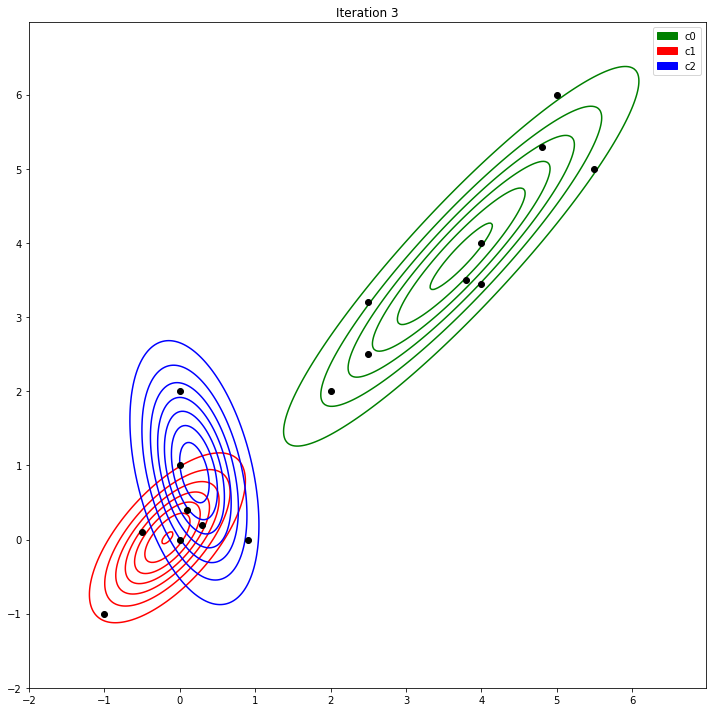

==============NOVA ITERACAO=================================
means: [[ 3.75566036  3.84334662]
 [-0.21981381 -0.04068974]
 [ 0.24190367  0.90032512]]
covs: [[[ 1.42922479  1.43066406]
  [ 1.43066406  1.69243429]]

 [[ 0.26218635  0.20861297]
  [ 0.20861297  0.30360076]]

 [[ 0.1436861  -0.20944095]
  [-0.20944095  0.67776437]]]
pis: [0.5349961864669145, 0.2764297638870029, 0.18857404964608265]


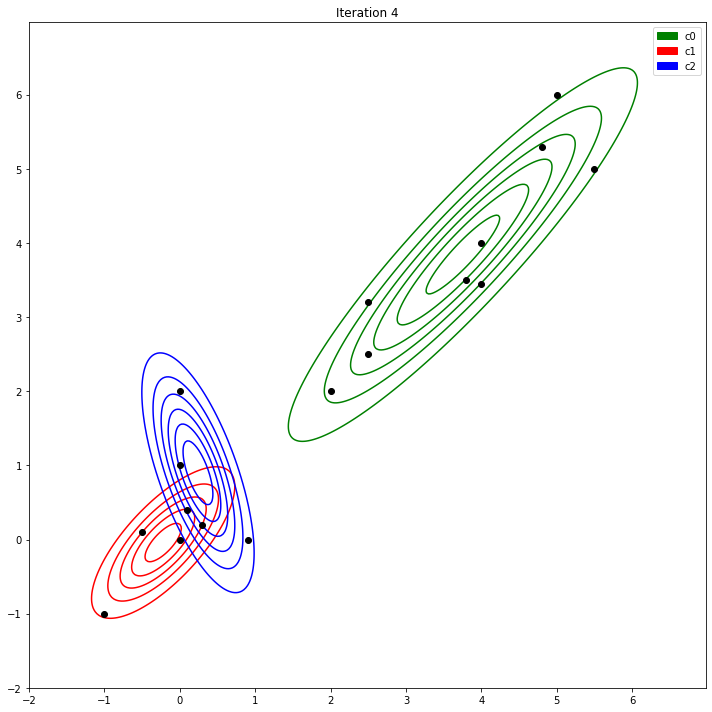

==============NOVA ITERACAO=================================
means: [[ 3.76652224  3.85669683]
 [-0.26945964 -0.08120376]
 [ 0.27480545  0.87480695]]
covs: [[[ 1.39964809  1.3940158 ]
  [ 1.3940158   1.64700084]]

 [[ 0.23155388  0.20681606]
  [ 0.20681606  0.28054872]]

 [[ 0.14640282 -0.23084267]
  [-0.23084267  0.64614533]]]
pis: [0.5331339092760605, 0.2613440138990317, 0.20552207682490786]


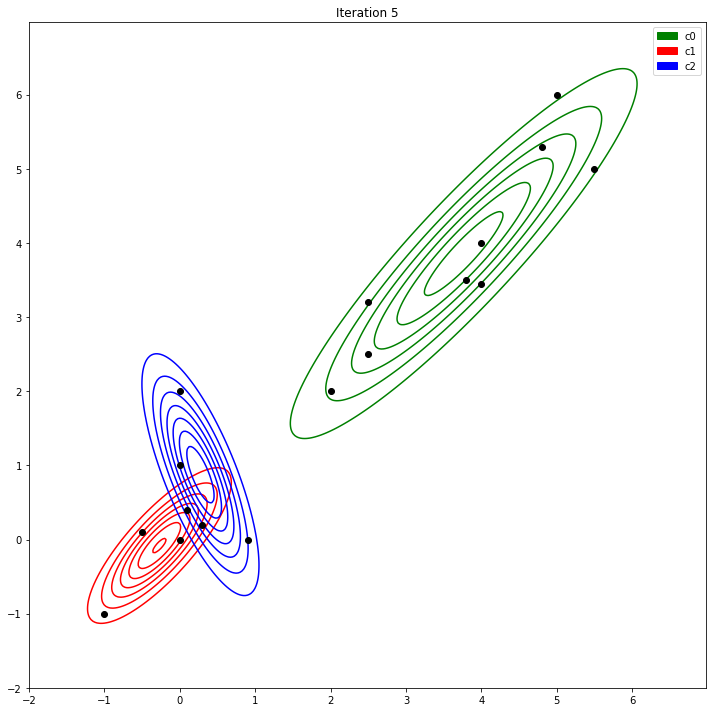

==============NOVA ITERACAO=================================
means: [[ 3.77201647  3.86377279]
 [-0.28610928 -0.09695736]
 [ 0.28515789  0.86860139]]
covs: [[[ 1.38539898  1.37521895]
  [ 1.37521895  1.62252969]]

 [[ 0.21847896  0.20482855]
  [ 0.20482855  0.26785154]]

 [[ 0.14921622 -0.2381467 ]
  [-0.2381467   0.63745905]]]
pis: [0.5321635079043835, 0.2566559798127472, 0.21118051228286938]


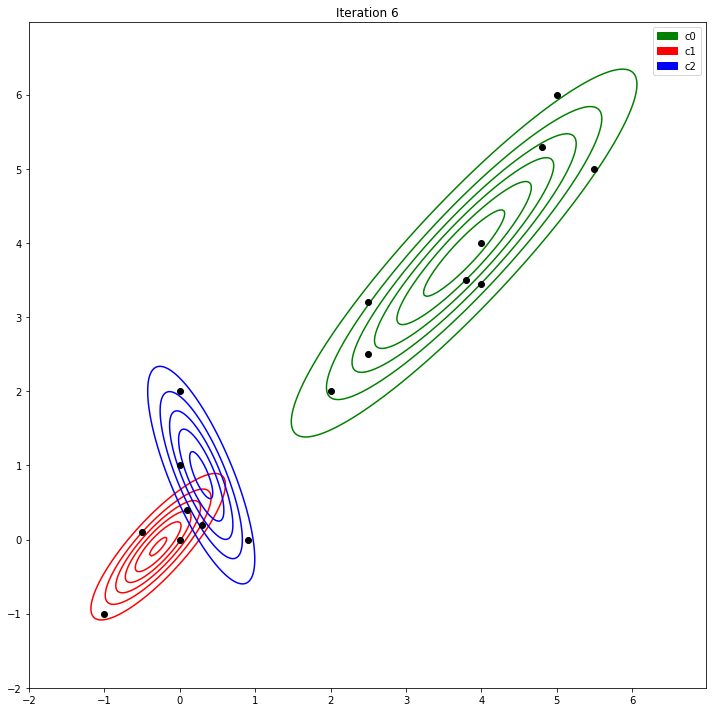

In [4]:
 means = np.array([
    [2, 2],
    [0, 0],
    [1,1]])

covariances = np.array([
    [[1, 0.1], [0.9, 1]],
    [[1, 0], [0, 1]],
    [[1, 0], [0, 1]]

])
weights = [0.33,0.33,0.33]
X = np.array([[-1,-1],[-0.5,0.1],[0.1,0.4],[2,2],[0,2],[0,1],[0.9,0],[0.3,0.2],[0,0],[2.5,2.5],[2.5,3.2],[4,4],[3.8,3.5],[4,3.45],[5.5,5],[5,6],[4.8,5.3]])

    
gmm = GMM(means,covariances,weights,X)
for x in range(0,7):
    print("==============NOVA ITERACAO=================================")
    print("means: " + str(gmm.get_means()))
    print("covs: " + str(gmm.get_covs()))
    print("pis: " + str(gmm.get_pis()))
    plot_contours(gmm, 'Iteration ' + str(x))
    gmm.EM()
